<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Synthetic-Data---Safe-Bayesian-Optimisation" data-toc-modified-id="Synthetic-Data---Safe-Bayesian-Optimisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Synthetic Data - Safe Bayesian Optimisation</a></span><ul class="toc-item"><li><span><a href="#Define-search-space" data-toc-modified-id="Define-search-space-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Define search space</a></span></li><li><span><a href="#Run-Safe-Bayesian-Optimisation" data-toc-modified-id="Run-Safe-Bayesian-Optimisation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run Safe Bayesian Optimisation</a></span></li><li><span><a href="#Plot-safe-boundary" data-toc-modified-id="Plot-safe-boundary-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot safe boundary</a></span></li><li><span><a href="#Plot-regret" data-toc-modified-id="Plot-regret-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot regret</a></span></li><li><span><a href="#Plot-distance-to-safe-boundary" data-toc-modified-id="Plot-distance-to-safe-boundary-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Plot distance to safe boundary</a></span></li></ul></li></ul></div>

# Synthetic Data - Safe Bayesian Optimisation

## Define search space

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from trieste.objectives.utils import mk_observer
from trieste.space import DiscreteSearchSpace

fig = plt.figure(facecolor=(1, 1, 1))
%matplotlib inline

from trieste.objectives import (
    lin_periodic, cosine_monotone
)

np.random.seed(1123)
tf.random.set_seed(1123)

# function_opt = cosine_monotone (f_syn_1)/lin_periodic (f_syn_2)
function_opt = cosine_monotone
beta = 5.0

dim = 2
num_per_dim = tf.constant(200)

coords_per_axis = tf.linspace(tf.constant([0.,0.], dtype=tf.float64), tf.constant([2,1], dtype=tf.float64), num_per_dim, axis=-1)

idx = list(range(1,coords_per_axis.shape[0]+1))
idx[-1] = 0

coords = tf.meshgrid(*tf.unstack(tf.gather(coords_per_axis, idx)))
coords = [tf.reshape(xv, [-1]) for xv in coords]
coords = tf.stack(coords, axis=-1)

search_space = DiscreteSearchSpace(coords)

def pred_f(x):
    return -1.0*function_opt(x)

## Run Safe Bayesian Optimisation

In [5]:
import trieste
import imageio
import gpflow
import random
import tensorflow_probability as tfp

from trieste.models.gpflow import GaussianProcessRegression, build_gpr
from trieste.acquisition.function import MonotoneSafeUCB, PredictiveVarianceSafe, SafeoptMonotone
from trieste.acquisition.rule import EfficientGlobalOptimization

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[.2, .2])
    prior_scale = tf.cast(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.cast(3, dtype=tf.float64), prior_scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr, num_kernel_samples=10)

observer = trieste.objectives.utils.mk_observer(function_opt)

# Select algorithm: change beta/L accordingly (if needed)
acq = MonotoneSafeUCB()
# acq = PredictiveVarianceSafe()
# acq = SafeoptMonotone()

rule = EfficientGlobalOptimization(builder=acq)
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
num_initial_points = 2

# Change to s=0 for both initial points for cosine_monotone function, else initial points may be unsafe
initial_query_points = tf.constant([[0.0, 2.0*random.random()], [0.0, 2.0*random.random()]], dtype=tf.float64)
initial_data = observer(initial_query_points)

model = build_model(initial_data)
bo_iter = 100
result = bo.optimize(bo_iter, initial_data, model, rule, track_state=True)

dataset = result.try_get_final_dataset()
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

Instructions for updating:
Use fn_output_signature instead
Optimization completed without errors
Trying to get dataset


## Plot safe boundary

Text(0, 0.5, 'x')

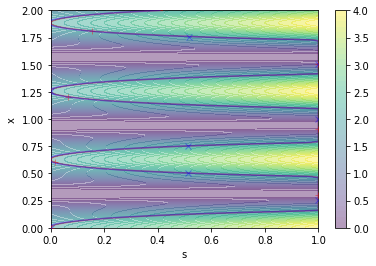

In [6]:
from util.plotting import plot_function_2d, plot_safe_boundary_2d

_, ax = plot_function_2d(
    pred_f,
    search_space.lower,
    search_space.upper,
    grid_density=400,
    alpha=0.4,
    fill=True
)

ax = plot_safe_boundary_2d(
    pred_f,
    ax[0][0],
    search_space.lower,
    search_space.upper,
    grid_density=200,
    plot_marker = '+',
    alpha=0.4,
    markevery=30
)

def pred_var(x):
    mean, var = result.history[-1].models["OBJECTIVE"].model.predict_f(x)
    return - mean + beta*tf.sqrt(var)
        
ax = plot_safe_boundary_2d(
    pred_var,
    ax,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    plot_color="blue",
    plot_marker = 'x',
    alpha=0.4,
    markevery=25
)

ax.set_xlabel("s")
ax.set_ylabel("x")

## Plot regret

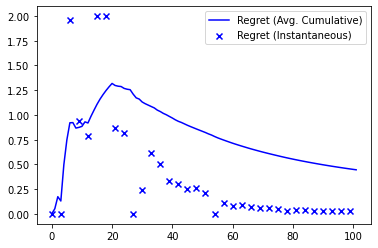

In [9]:
def plot_cumulative_regret(
    obs_values,
    ax,
    label,
    obs_every = 3,
    show_obs=False,
    c = "blue",
):
    
    cum_values = np.cumsum(obs_values)
    cum_values_t = [cum_values[i]/(i+1) for i in range(len(obs_values))]
    ax.plot(cum_values_t, color=c, label=label + " (Avg. Cumulative)")
        
    if show_obs:
        obs_values = np.mean(obs_values, axis = 1)
        ax.scatter(range(0,obs_values.shape[0],obs_every), obs_values[0::obs_every], c=c, marker='x', label=label+" (Instantaneous)")

thres = -2.0*tf.ones(observations.shape, observations.dtype)

suboptimality = observations - thres.numpy()
_, ax = plt.subplots(1, 1)

plot_cumulative_regret(
    suboptimality, ax, label = "Regret", show_obs = True
)

ax.legend(loc='upper right')

## Plot distance to safe boundary

Trying to get dataset


Text(0.5, 0, 't')

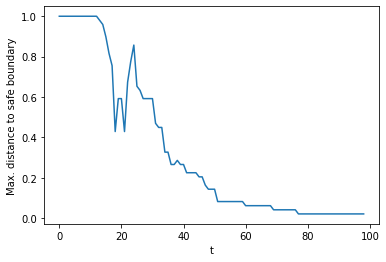

In [12]:
import matplotlib.pyplot as plt
from util.plotting import create_grid
from trieste.utils import to_numpy

query_point, observation, arg_min_idx = result.try_get_optimal_point()
# dataset = result.try_get_final_dataset()
# query_points = dataset.query_points.numpy()
# observations = dataset.observations.numpy()
    
save_fig_bool = True
num_initial_points = 2
thres = 2.0

def find_avg_dist(result, function_opt, mins, maxs, grid_density, return_avg = False):
    avg_dist = []

    mins = to_numpy(mins)
    maxs = to_numpy(maxs)

    Xplot, xx, yy = create_grid(mins=mins, maxs=maxs, grid_density=grid_density)
    F = to_numpy(function_opt(Xplot))
    F = F.flatten()
    F = -1.*F.reshape((grid_density, grid_density))

    max_s = []
    for i in range(grid_density):
        j = 1
        if F[i,j-1] > thres or F[i,j] > thres:
            max_s.append(0)
            continue
        while F[i,j-1] <= thres and F[i, j] <= thres:
            j += 1
            if j == grid_density:
                break
        max_s.append(xx.flatten()[j-1])
    
    last_UCB = None
    for k in range(1, bo_iter):
        def pred_UCB(x):
            mean, var = result.history[k].models["OBJECTIVE"].model.predict_f(x)
            return - mean + beta*tf.sqrt(var)
        F = to_numpy(pred_UCB(Xplot))
        F = F.flatten()
        F = F.reshape((grid_density, grid_density))
        max_s_curr = []
        for i in range(grid_density):
            j = 1
            if F[i,j-1] > 2.0 or F[i,j] > 2.0:
                max_s_curr.append(0)
                continue
            
            while F[i,j-1] <= 2.0 and F[i, j] <= 2.0:
                j += 1
                if j == grid_density:
                    break            
            max_s_curr.append(xx.flatten()[j-1])

        diff_s_curr = np.array(max_s) - np.array(max_s_curr)
        if return_avg:
            avg_dist.append(np.mean(diff_s_curr))
        else:
            avg_dist.append(np.max(diff_s_curr))
    
    return avg_dist


dists = find_avg_dist(result = result, function_opt = function_opt, mins = search_space.lower, 
                         maxs = search_space.upper, grid_density = 50, return_avg = False)

_, ax = plt.subplots(1, 1)
ax.plot(dists)

ax.set_ylabel("Max. distance to safe boundary")
ax.set_xlabel("t")
